In [ ]:
!pip3 install git+https://github.com/huggingface/transformers.git

In [ ]:
!pip3 install datasets soundfile speechbrain==0.5.16 accelerate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

/Users/qiaoheqi/anaconda3/envs/dl4m-hw3-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model and Vocoder

In [2]:
from transformers import SpeechT5ForTextToSpeech


model_dir = "speecht5_finetuned_voxpopuli_nl"


model = SpeechT5ForTextToSpeech.from_pretrained("speecht5_finetuned_voxpopuli_nl")#.to("cuda:0")


from transformers import (
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    SpeechT5FeatureExtractor,
    SpeechT5Processor,
)
vocoder = SpeechT5HifiGan.from_pretrained(
        "microsoft/speecht5_hifigan", torch_dtype=torch.float
    )

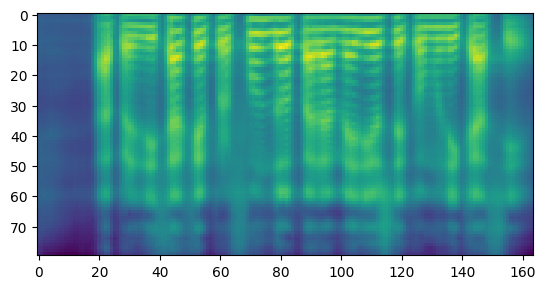

In [15]:
text = "aprendizaje profundo para medios de comunicación" #Deeplearning for Media in Spanish
speaker_embeddings = torch.load("SpeakerMan2.pt")#Pick a speaker

inputs = processor(text=text, return_tensors="pt")
#spectrogram = model.generate_speech(inputs["input_ids"].to("cuda:0"), speaker_embeddings.to("cuda:0"))
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
#spectrogram_cpu = spectrogram.to("cpu")
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [16]:
# Now let's listen...
with torch.no_grad():
    
    speech = vocoder(spectrogram)

from IPython.display import Audio

Audio(speech.to("cpu").numpy(), rate=16000)